In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import math
from google.colab.patches import cv2_imshow
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Mount Drive
## Images as well as annotations are present 

from google.colab import drive
drive.mount('/content/drive')

In [3]:
import numpy as np
import librosa
import os
from keras.utils import to_categorical

def wav2mfcc(file_path, max_pad_len=20):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

def get_data():

    labels = []
    mfccs = []
    filename = 'drive/My Drive/Speech/free-spoken-digit-dataset/train/'

    for f in os.listdir(filename):
        if f.endswith('.wav'):
            # MFCC
            mfccs.append(wav2mfcc(filename + f))

            # List of labels
            label = f.split('_')[0]
            labels.append(label)

    return np.asarray(mfccs), labels

Using TensorFlow backend.


In [4]:
## Test Data
data, labels = get_data()
print('Data length', len(data))
print('Labels Length', len(labels))
print('Data shape', data.shape)
print('Data[0] shape', data[0].shape)
print('Data[1] shape', data[1].shape)
d = data[0].flatten()
print(len(d))

Data length 100
Labels Length 100
Data shape (100, 20, 20)
Data[0] shape (20, 20)
Data[1] shape (20, 20)
400


In [5]:
import random
def load_data(data, labels):
  dictionary = {}
  for i in range(len(data)):
    d = data[i]
    l = labels[i]
    f = d.flatten()
    dictionary[i] = [f,l]

  keys =  list(dictionary.keys())
  print(len(keys))
  random.shuffle(keys)
  d = dict([(key, dictionary[key]) for key in keys])
  # print(d[1])
  Q = np.array(list(d.values()))
  print(Q.shape)
  lab = Q[:, 1]
  lab = to_categorical(lab)
  data_flatten = []
  for ele in np.array(Q[:,0]):
    ele= ele.ravel()
    data_flatten.append(ele)
  data_flatten = np.array(data_flatten)
  print(data_flatten.shape)
  X_train = np.array(data_flatten[:90])
  Y_train = lab[:90]

  X_test = np.array(data_flatten[90:])
  Y_test = lab[90:]

  return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_data(data, labels)

100
(100, 2)
(100, 400)


In [6]:
print(X_train.shape)


(90, 400)


In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

#from ann_visualizer.visualize import ann_viz

def get_ann_model(input_shape, num_classes):
    model = Sequential()

    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    # model.add(Dense(128, activation='relu'))
    # model.add(BatchNormalization())

    # model.add(Dense(128,  activation='relu'))
    # model.add(BatchNormalization())

    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               102656    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

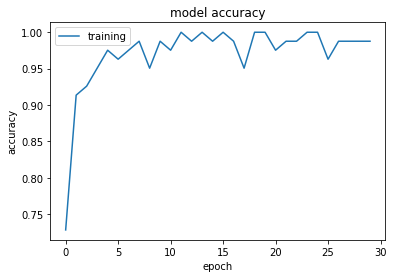

In [18]:
import matplotlib.pyplot as plt
## Train model
model = get_ann_model((400,), 2)
print(model.summary())
history = model.fit(np.array(X_train), Y_train, batch_size=10, epochs=30, verbose=0, validation_split=0.1)
print(history.history['accuracy'][-1])
plt.plot(history.history['accuracy'])
#plt.plot(self.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [19]:
# print(X_test)
y_test = model.predict_classes(X_test)

In [20]:
count =0 
print(y_test[0])
# Y_test_ = to_categorical(Y_test)
for i in range(len(Y_test)):
  if Y_test[0][0]==1:
    y=0
  else:
    y=1
  if(y == y_test[i]):
    count+=1

print(count/len(y_test))

0
0.7
